In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from pprint import pprint
from itertools import chain

from IPython.display import Image, display
from lark import tree as larkTree
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

from lark import Lark, Token, Transformer
from lark.indenter import Indenter

def display_tree(t, filename='viz.png'):
    larkTree.pydot__tree_to_png(t, filename)
    display(Image(filename))
    os.remove(filename)
    

def display_graph(g, filename='viz.png'):
    A = to_agraph(g)
    A.layout('dot')
    A.draw(filename)
    display(Image(filename))
    os.remove(filename)


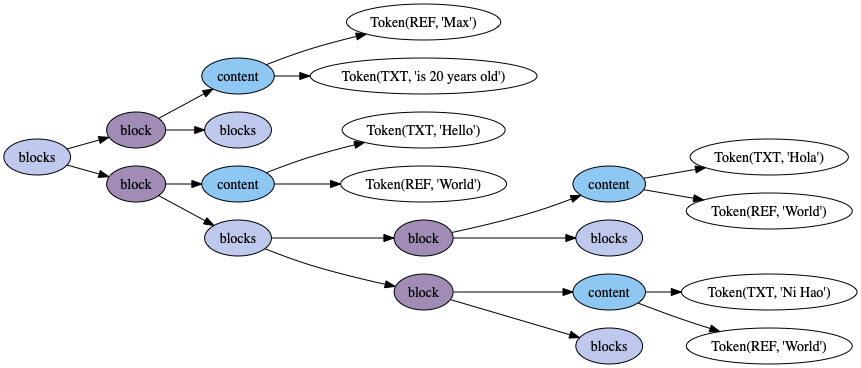

In [24]:
NOTES_FOLDER = './note_files/'

GRAMMAR = open('./grammar.lark').read()

class TreeIndenter(Indenter):
    """A lexical processor for indentation"""
    NL_type = '_NL'
    OPEN_PAREN_types = ["OPEN_REF"]
    CLOSE_PAREN_types = ["CLOSE_REF"]
    INDENT_type = '_INDENT'
    DEDENT_type = '_DEDENT'
    tab_len = 8


class TreeTransformer(Transformer):
    """Pos-processing to modify the lark generated tree"""
    @staticmethod
    def text(items):
        """Join words under text nodes in the AST"""
        return Token('TXT', ' '.join(items))

    @staticmethod
    def reference(items):
        """Join words under reference nodes in the AST"""
        return Token('REF', ' '.join(items))

PARSER = Lark(
    GRAMMAR,
    parser='lalr',
    postlex=TreeIndenter(),
    transformer=TreeTransformer)


def ast_from_text(text):
    """Parse text into an array of block ASTs"""
    return PARSER.parse(text)

x = ast_from_text('''
- [[Max]] is 20 years old
- Hello [[World]]
  - Hola [[World]]
  - Ni Hao [[World]]
''')

display_tree(x)

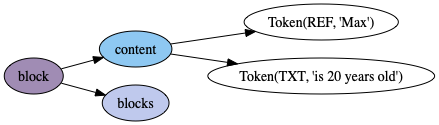

In [25]:
# Get trees with data
all_blocks = list(x.find_data('block'))
display_tree(all_blocks[0])


In [26]:
# assign IDs to each block
id_to_block = {}
block_to_id = {}
for i, block in enumerate(all_blocks):
    _id = str(i)
    id_to_block[_id] = block
    block_to_id[block] = _id

print('id to block:')
print(list(id_to_block.items())[0])

print('block to id:')
print(list(block_to_id.items())[0])

id to block:
('0', Tree(block, [Tree(content, [Token(REF, 'Max'), Token(TXT, 'is 20 years old')]), Tree(blocks, [])]))
block to id:
(Tree(block, [Tree(content, [Token(REF, 'Max'), Token(TXT, 'is 20 years old')]), Tree(blocks, [])]), '0')


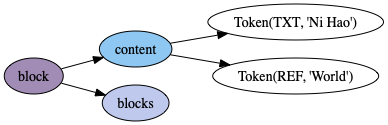

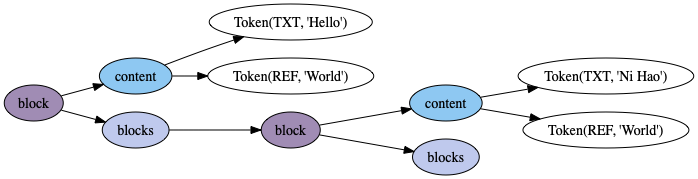

In [22]:
# get blocks containing a reference with <value>
def get_blocks_with_ref(value):
    results = []
    for block in all_blocks:
        for token in block.children[0].children:
            if token.type == 'REF' and token.value == value:
                results.append(block)
    return results

for b in get_blocks_with_ref('World'):
    display_tree(b)

parent:


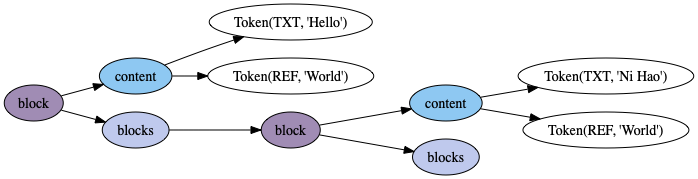

children:


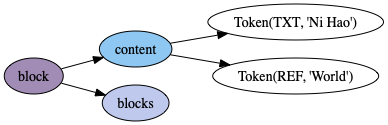

In [23]:
# Get immediate children blocks of <parent> block
def get_immediate_children(parent):
    return list(parent.children[1].children)
    
parent = x.children[1]
print('parent:')
display_tree(parent)
print('children:')
for b in get_immediate_children(parent):
    display_tree(b)

child:


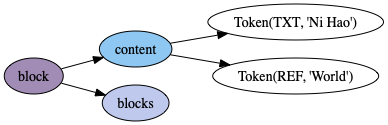

parent:


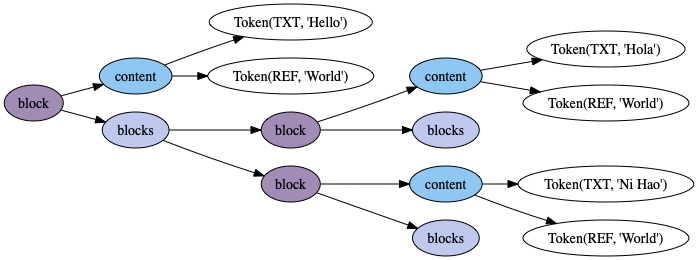

In [28]:
# get immediate parent block of <child> block
def get_immediate_parent(child):
    for block in all_blocks:
        if child in block.children[1].children:
            return block

child = all_blocks[2]
print('child:')
display_tree(child)

print('parent:')
display_tree(get_immediate_parent(child))

- a textblock's children are it's immediate children as well as any children to textblock's which are references to it

- occurences of a textblock are any other textblocks with content that includes a reference to it (via id, etc) AND other textblocks which are parents of it and its immediate parent.


- textblocks are indexed by id primarily, references, etc are secondary. When you use a special link, it must be resolved to an id

    - and special links must be resolved while searching for occurences/children